In [1]:
%cd ..

/home/rehak/repos/ops/ecris.analysis


In [9]:
from pathlib import Path
import random
import joblib

from ops.ecris.analysis.io import read_csd_from_file_pair
from ops.ecris.analysis.csd import estimate_m_over_q, rescale_m_over_q
from ops.ecris.analysis.csd.ml import find_oxygen_peaks

model = joblib.load('models/oxygen_nn/mlp_csd_oxygen.pkl')
CSD_FILEPATHS = list(Path('./data/csds').glob('csd_*'))
FILE_NUM = random.randint(0, len(CSD_FILEPATHS))
csd = read_csd_from_file_pair(CSD_FILEPATHS[FILE_NUM]) 
csd.m_over_q = estimate_m_over_q(csd)
ml_peaks, probability = find_oxygen_peaks(csd, model)
csd.m_over_q = rescale_m_over_q(csd.m_over_q, ml_peaks)

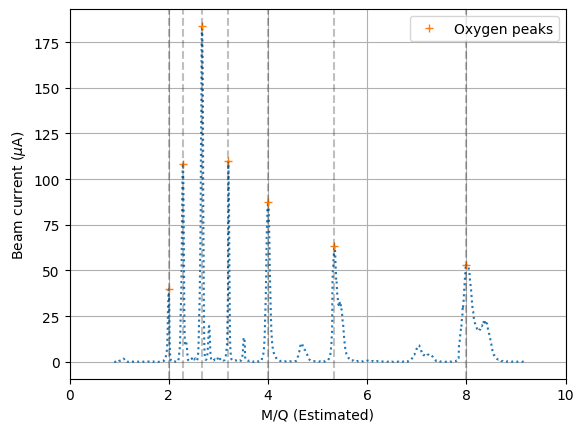

Estimated probability of O2 detection: 0.8982225286310243


In [10]:
import matplotlib.pyplot as plt
plt.plot(csd.m_over_q, csd.beam_current, ':')
plt.plot(ml_peaks.m_over_q, ml_peaks.beam_current, '+', label='Oxygen peaks')
for i in range(1, 9):
    plt.axvline(16/i, ls='--', alpha=0.25, c='k')
plt.xlabel('M/Q (Estimated)')
plt.ylabel(r'Beam current ($\mu$A)')
plt.xlim([0,10])
plt.grid()
plt.legend()
plt.show()
print(f'Estimated probability of O2 detection: {probability}')